<a href="https://colab.research.google.com/github/mjkimcs/portfolio/blob/master/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EB%B6%84%EB%A5%98/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

X, y
1. 트레인셋 : X_trn1, y_trn1 : X_trn, X_val, y_trn, y_val
2. 테스트셋 : X_tst, y_tst

In [ ]:
# 원본 [X, y]를 피쳐엔지니어링이 끝나면 feature.csv로 저장하기

data_dir = Path('./open')
feature_file = data_dir / 'feature.csv'

df.to_csv(feature_file)
df = pd.read_csv(feature_file, index_col=0)
df.head()

In [ ]:
# feature.csv를 train.csv와 test.csv로 분리하여 저장하기

# 우선 전체데이터를 8:2(학습1:테스트)  # 총400을 320:80
# 학습1데이터를 다시 8:2(학습:검증)  # 총320을 256:64

data_dir = Path('./open')
feature_file = data_dir / 'feature.csv'
trn1_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'

df = pd.read_csv(feature_file, index_col=0)
target_col = 'class' # y 컬럼명

trn1 = df.iloc[:320000]
df.drop(target_col, axis=1, inplace=True)
X_tst = df.iloc[320000:]

trn1.to_csv(trn1_file)
X_tst.to_csv(tst_file)
trn1 = pd.read_csv(feature_file, index_col=0)
df = pd.read_csv(feature_file, index_col=0)


# 참고
df = pd.concat([trn1, tst], axis=0)
print(df.shape)
df.tail()

In [ ]:
# kaggler
vs_buildtools__185481535.1628470069.exe 설치(드롭박스에 있음)
https://github.com/mjkimcs/Kaggler
클론 후 Anaconda Prompt : python setup.py install

pip install absl_py
pip install gast
pip install astunparse
pip install keras_preprocessing
pip install flatbuffers


# graphviz
https://graphviz.org/download/ 64비트 다운로드
시스템 변수 : C:\Program Files\Graphviz\bin\dot.exe

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import graphviz
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import warnings

from tensorflow import keras
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model, to_categorical

In [ ]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [ ]:
data_dir = Path('./open')

trn1_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'

target_col = 'class'
n_fold = 5
n_class = 2
seed = 42

In [ ]:
algo_name = 'rfcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = data_dir / f'{feature_name}.csv'
p_val_file = data_dir / f'{model_name}.val.csv'
p_tst_file = data_dir / f'{model_name}.tst.csv'

< 변수 >  
1. 범주형
 - 명목형
 - 순서형 : 매우만족(1)

2. 수치형 : 1이 진짜 1만큼의 수치적인 의미를 가짐
 - 연속형
 - 이산형 : 건수

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# 수치형 변수변환
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler # 아웃라이어에 영향을 덜 받음
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer # 멱함수를 정규분포로

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(data=df_scaled, index=df.index, columns=scale_cols)
df_scaled.columns = scale_cols
df_concat = pd.concat([df_scaled, X_cat], axis=1)

In [ ]:
# 범주형 변수변환
# linear/logistic regression, 딥러닝, SVM 등의 알고리즘은 명목형을 수치로 변환 시 학습성능이 떨어지는 경우가 많아서 One-Hot인코딩으로 해결함
from sklearn.preprocessing import LabelEncoder # 남자:0
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder # 매우만족:5 


df['release_time'] = pd.to_datetime(df['release_time'])
print(df['release_time'].dtype) # datetime64[ns]

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score

lr = LogisticRegression()
lr.fit(X, y)
p = lr.predict_proba(X)[:, 1]

print(lr.intercept_)
print(lr.coef_)
print(X.columns)

In [ ]:
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, confusion_matrix

confusion_matrix(y, np.argmax(p_val, axis=1)) # 실제값, 예측값  # [결과]예측(가로축)-실제(세로축)
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100 :.4f}%')

In [ ]:
# 학습 / 검증 / 테스트로 나누기
# 학습1 = 학습 + 검증
# 우선 전체데이터를 8:2(학습1:테스트)  # 총400을 320:80
# 학습1데이터를 다시 8:2(학습:검증)  # 총320을 256:64

target_col = 'class' # y 컬럼명
y_trn1 = df[target_col].values[:320000] # 학습1에서 y값

df.drop(target_col, axis=1, inplace=True)
X_trn1 = df.iloc[:320000].values # 학습1에서 X값
X_tst = df.iloc[320000:].values # 테스트에서 X값

feature_name = df.columns.tolist() # ndaaray를 df로 바꿀 때 필요
print(y.shape, X.shape, tst.shape)

X_trn, X_val, y_trn, y_val = train_test_split(X_trn1, y_trn1, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

In [ ]:
# Hold-out Validation
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

X_trn, X_val, y_trn, y_val = train_test_split(X_trn1, y_trn1, test size=.3, random_state=seed)

## N-fold Cross-Validation
- 과적합을 방지하기 위해서는 테스트셋을 늘려야 함
- 교차검증은 학습데이터를 100% 활용하는 것이 가능하여 과적합의 위험을 줄일 수 있음
- 전체 train셋에 대해서 예측값을 얻을 수 있음
- n_splits : fold의 갯수
- 각각의 fold에서 선정된 모델들을 사용해서 test셋을 예측한 후 평균낸 값을 최종 정답으로 결정  
  
## Stratified N-fold Cross-Validation
- 각각의 폴드에서 종속변수의 분포가 동일하도록 폴드를 구성
- 종속변수의 범주 분포가 균일하지 않을 때 사용

In [ ]:
# LGBM
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

target_col = "income"
y_trn1 = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
X_trn1 = df.iloc[:320000].values
X_tst = df.iloc[320000:].values
feature_name = df.columns.tolist()

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
p_val = np.zeros((X_trn1.shape[0], n_class)) # 0으로 초기화
p_tst = np.zeros((X_tst.shape[0], n_class)) # 0으로 초기화

for i, (i_trn, i_val) in enumerate(cv.split(X_trn1, y_trn1), 1): # 학습1셋에서 학습/검증 인덱스를 가져옴
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='binary',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=0.1,
                             min_child_samples=10,
                             subsample=.5,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=seed,
                             n_jobs=-1)
    
    clf.fit(X_trn1[i_trn], y_trn1[i_trn],
            eval_set=[(X_trn1[i_val], y_trn1[i_val])],
            eval_metric='binary',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(X_trn1[i_val]) # 학습1셋 전체 y에 대한 예측
    p_tst += clf.predict_proba(X_tst) / n_fold # 

print(f'{accuracy_score(y_trn1, np.argmax(p_val, axis=1)) * 100:.4f}%') # 학습1셋 전체 y에 대한 예측값 vs 실제값

np.savetxt(p_val_file, p_val, fmt="%.6f", delimiter=",") # for stacking # p_val_file : 위에서 지정해준 파일경로
np.savetxt(p_tst_file, p_tst, fmt="%.6f", delimiter=",") # for stacking

In [ ]:
# RF
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

target_col = "income"
y_trn1 = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
X_trn1 = df.iloc[:320000].values
X_tst = df.iloc[320000:].values
feature_name = df.columns.tolist()

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
p_val = np.zeros((X_trn1.shape[0], n_class))
p_tst = np.zeros((X_tst.shape[0], n_class))

for i, (i_trn, i_val) in enumerate(cv.split(X_trn1, y_trn1), 1):
    print(f'training model for CV #{i}')
    clf = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf=10,
                                 max_features='auto',
                                 max_samples=.5,
                                 random_state=seed,
                                 n_jobs=-1)
    clf.fit(X_trn1[i_trn], y_trn1[i_trn])
    p_val[i_val, :] = clf.predict_proba(X_trn1[i_val])
    p_tst += clf.predict_proba(X_tst) / n_fold

print(f'{accuracy_score(y_trn1, np.argmax(p_val, axis=1)) * 100:.4f}%')

np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [ ]:
# LR Polynomial Feature 생성(선택사항)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

scaler = StandardScaler()
poly = PolynomialFeatures(2)
X = poly.fit_transform(scaler.fit_transform(df.drop(target_col, axis=1))) # 문자형 데이터가 없는 전처리가 완료된 df 준비
feature_names = poly.get_feature_names(df.columns)

df_poly = pd.DataFrame(data=X, columns=feature_names, index=df.index)
df_poly[target_col] = df[target_col]
df_poly.to_csv(feature_file)
del df_poly, df
df = pd.read_csv(feature_file, index_col=0)
df.head()

In [ ]:
# LR
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score

target_col = "income"
y_trn1 = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
X_trn1 = df.iloc[:320000].values
X_tst = df.iloc[320000:].values
feature_name = df.columns.tolist()

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
p_val = np.zeros((X_trn1.shape[0], n_class))
p_tst = np.zeros((X_tst.shape[0], n_class))

for i, (i_trn, i_val) in enumerate(cv.split(X_trn1, y_trn1), 1):
    print(f'training model for CV #{i}')
    clf = LogisticRegression()
    clf.fit(X_trn1[i_trn], y_trn1[i_trn])
    p_val[i_val, :] = clf.predict_proba(X_trn1[i_val])
    p_tst += clf.predict_proba(X_tst) / n_fold
    
print(f'{accuracy_score(y_trn1, np.argmax(p_val, axis=1)) * 100:.4f}%')
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [ ]:
# NN
# LR과 똑같이 Polynomial Feature 생성(선택사항)
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from tensorflow import keras
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model, to_categorical

target_col = "income"
y_trn1 = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
X_trn1 = df.iloc[:320000].values
X_tst = df.iloc[320000:].values
feature_name = df.columns.tolist()

def get_model():
    inputs = Input(shape=(len(feature_name),))
    x = Dense(64, activation='relu')(inputs)
    # x = Dense(64, activation='relu')(x)
    # x = Dense(128, activation='relu')(x)
    # x = Dense(128, activation='relu')(x)

    # x = Dense(32, activation='relu')(inputs)
    # x = Dense(32, activation='relu')(x)
    # x = Dense(128, activation='relu')(x)
    outputs = Dense(n_class, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
p_val = np.zeros((X_trn1.shape[0], n_class))
p_tst = np.zeros((X_tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(X_trn1, y_trn1), 1):
    print(f'training model for CV #{i}')
    clf = get_model()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                            patience=3, min_lr=1e-6, mode='min', verbose=1)

    clf.fit(X_trn1[i_trn], 
            to_categorical(y_trn1[i_trn]),
            validation_data=(X_trn1[i_val], to_categorical(y_trn1[i_val])),
            epochs=10,
            callbacks=[es, rlr])
    p_val[i_val, :] = clf.predict(X_trn1[i_val])
    p_tst += clf.predict(X_tst) / n_fold

print(f'{accuracy_score(y_trn1, np.argmax(p_val, axis=1)) * 100:.4f}%')

np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

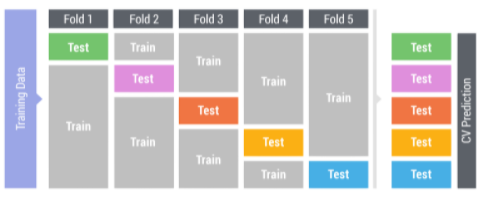

## Hyperopt, Optuna
- randomize search보다 좋은 성능을 얻을 수 있음
- 그리드/베이지안 서치보다 더 빨리 수렴함

[참고]  
1. GridSearchCV
 - 검색하고자하는 피처 값들의 모든 조합을 사용하여 모델을 학습/검증 후 최고의 모델 선택
2. RandomizedSearchCV
 - 검색하고자하는 피처 값들의 조합 중 N개의 조합을 임의로 선택하여 모델을 학습/검증 후 최고의 모델 선택
 - 피처 값의 범위 혹은 분포를 지정할 수 있음

### Hyperopt
- 가장 널리 사용되는 모델튜닝(HPO) 라이브러리 중 하나
- TPE(Tree-structured Parzen Estimator) 알고리즘 사용
- 시간이 많이 걸릴 경우 샘플링한 데이터의 하이퍼파라미터를 찾은 후에 그 하이퍼파라미터로 전체 데이터를 학습하는 방법도 있음

In [ ]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
import seaborn as sns
import warnings

In [ ]:
seed = 42
target_col = 'income' # y 컬럼명
y_trn1 = df[target_col].values[:320000] # 학습1에서 y값
y_tst = df[target_col].values[26000:] # 테스트에서 y값

df.drop(target_col, axis=1, inplace=True)
X_trn1 = df.iloc[:320000].values # 학습1에서 X값
X_tst = df.iloc[320000:].values # 테스트에서 X값

feature_name = df.columns.tolist() # ndaaray를 df로 바꿀 때 필요
print(y.shape, X.shape, tst.shape)

X_trn, X_val, y_trn, y_val = train_test_split(X_trn1, y_trn1, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

In [ ]:
# 기본 params 먼저 확인
clf0 =  lgb.LGBMClassifier( )
clf0.fit(X_trn1, y_trn1)

In [ ]:
# 기본 ACC 확인
y_pred =  lgbm.predict(X_tst)
acc =  accuracy_score(y_tst, y_pred)
print('LGBM Base Model accuracy score : {0:0.4f}'.format(acc))

cm_lgbm =  classification_report(y_tst, y_pred)
print(cm_lgbm)

In [ ]:
params = {
    "objective": "binary",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "random_state": 0,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [15, 31, 63, 127]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .5, .9, 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100])
}

In [ ]:
# 확률이 낮아질 수록 logloss값이 기하급수적으로 증가
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="binary_logloss",
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["binary_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params) # 최적의 params

In [ ]:
n_fold = 5
n_class = 2
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)
p_val = np.zeros((X_trn1.shape[0], n_class))
p_tst = np.zeros((X_tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(X_trn1, y_trn1), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_trn1[i_trn], y_trn1[i_trn],
            eval_set=[(X_trn1[i_val], y_trn1[i_val])],
            eval_metric='binary',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(X_trn1[i_val])
    p_tst += clf.predict_proba(X_tst) / n_fold

In [ ]:
print(f'{accuracy_score(y_trn1, np.argmax(p_val, axis=1)) * 100:.4f}%')
print(f'{accuracy_score(y_tst, np.argmax(p_tst, axis=1)) * 100:.4f}%')

In [ ]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

### Optuna
- 최근 각광받고 있는 모델튜닝(HPO) 라이브러리
- 기존 HPO 라이브러리들의 장점(Pruning-과적합 방지, Lightweight, Distributed, Dashboard, OSS)을 결합
- 단순한 API : define-by-run 방식으로 연산정의와 값 초기화가 동시에 됨, 값을 담을 공간 관리가 필요없고 모델 그래프를 데이터에 따라 쉽게 조절할 수 있어 편리함, 코드도 대체로 짧아짐

In [ ]:
import optuna.integration.lightgbm as lgb  # pip install optuna
from lightgbm import LGBMClassifier ## 이것이 좀 다름
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [ ]:
seed = 42
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "lambda_l1": 0.,
    "lambda_l2": 0.,
    "random_state": seed,
    "n_jobs": -1,
}

In [ ]:
dtrain = lgb.Dataset(X_trn, label=y_trn)
dval = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, dtrain, valid_sets=[dtrain, dval], 
                  verbose_eval=100, early_stopping_rounds=10)

preds = model.predict(X_val, num_iteration=model.best_iteration) # Optuna는 binary classification에서 n_class가 1이라서 predict값도 1개씩만 나옴
prediction = (preds >= 0.5).astype('int') # thresholds가 0.5인 경우
accuracy = accuracy_score(y_val, prediction)

params = model.params
print("Best params:", params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in params.items():
    print("    {}: {}".format(key, value))

In [ ]:
n_fold = 5
n_class = 2
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)
p_val = np.zeros((X_trn1.shape[0], n_class))
p_tst = np.zeros((X_tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(X_trn1, y_trn1), 1):
    print(f'training model for CV #{i}')
    clf = LGBMClassifier(**params)
    clf.fit(X_trn1[i_trn], y_trn1[i_trn],
            eval_set=[(X_trn1[i_val], y_trn1[i_val])],
            eval_metric='binary',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(X_trn1[i_val])
    p_tst += clf.predict_proba(X_tst) / n_fold

In [ ]:
print(f'{accuracy_score(y_trn1, np.argmax(p_val, axis=1)) * 100:.4f}%')
print(f'{accuracy_score(y_tst, np.argmax(p_tst, axis=1)) * 100:.4f}%')

In [ ]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [ ]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

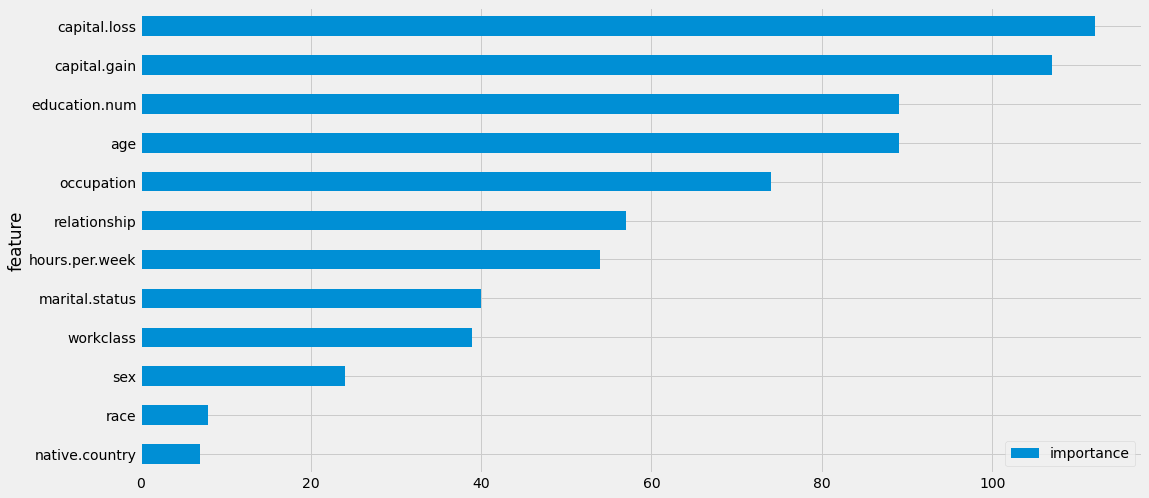

In [ ]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh');

## Stacking

In [ ]:
data_dir = Path('./open')

trn1_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'

target_col = 'class'
n_fold = 5
n_class = 2
seed = 42

In [ ]:
algo_name = 'lgbcv'
feature_name = 'stacking1'
model_name = f'{algo_name}_{feature_name}'

p_val_file = data_dir / f'{model_name}.val.csv'
p_tst_file = data_dir / f'{model_name}.tst.csv'

In [ ]:
model_names = ['lrcv_polyfeature', 'rfcv_feature', 'lgbcv_feature']
X_trn1 = []
X_tst = []
feature_names = []
for i in model_names:
    X_trn1.append(np.loadtxt(data_dir / f'{i}.val.csv', delimiter=','))
    X_tst.append(np.loadtxt(data_dir / f'{i}.tst.csv', delimiter=','))
    feature_names += [f'{i}_class0', f'{i}_class1']
    
X_trn1 = np.hstack(X_trn1)
X_tst = np.hstack(X_tst)

In [ ]:
y_trn1 = pd.read_csv(trn1_file, index_col=0, usecols=['id', target_col]).values.flatten()
y_trn1.shape

In [ ]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

# 옵션1. LGBM
p_val = np.zeros((X_trn1.shape[0], n_class))
p_tst = np.zeros((X_tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(X_trn1, y_trn1), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='binary',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=0.1,
                             min_child_samples=10,
                             subsample=.5,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(X_trn1[i_trn], y_trn1[i_trn],
            eval_set=[(X_trn1[i_val], y_trn1[i_val])],
            eval_metric='binary',
            early_stopping_rounds=10)
    p_val[i_val, :] = clf.predict_proba(X_trn1[i_val])
    p_tst += clf.predict_proba(X_tst) / n_fold

# 옵션2. LR
p_val = np.zeros((X_trn1.shape[0], n_class))
p_tst = np.zeros((X_tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(X_trn1, y_trn1), 1):
    print(f'training model for CV #{i}')
    clf = LogisticRegression()
    clf.fit(X_trn1[i_trn], y_trn1[i_trn])
    p_val[i_val, :] = clf.predict_proba(X_trn1[i_val])
    p_tst += clf.predict_proba(tst) / n_fold


print(f'{accuracy_score(y_trn1, np.argmax(p_val, axis=1)) * 100:.4f}%')

np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh');

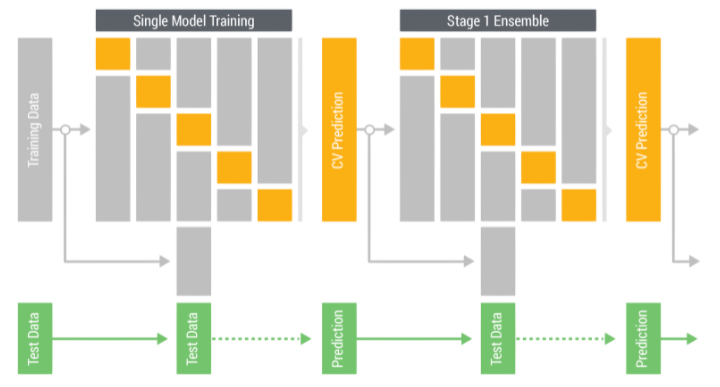

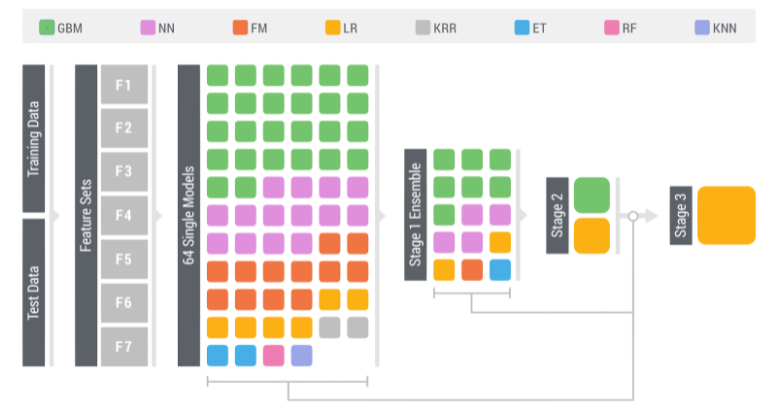

## 최종 성능 향상에 큰 도움을 주는 방법의 순위
1. 피쳐 엔지니어링 : 예측성능이 좋은 굉장히 좋은 피쳐를 발견, 1~2% 정도 성능향상
2. 굉장히 좋은 base learner를 학습 : 각 모델의 하이퍼파라미터 튜닝을 통해 각 모델 성능을 최적화, 0.5~0.9% 정도 성능향상
3. Stacking은 사실 1,2번이 뒷받침된 후에 0.1% 정도로 성능을 향상시킴

## 컬럼 생성

In [ ]:
train["Fare_cat"] = np.where((train.Fare < 15), "Low", np.nan)
train["Fare_cat"] = np.where((train.Fare >= 15) & (train.Fare < 35), "Medium", train.Fare_cat)
train["Fare_cat"] = np.where((train.Fare >= 35), "High", train.Fare_cat)

train.groupby(["Sex", "Fare_cat"])["Survived",].mean()

In [ ]:
df.loc[ df['class'] == -1, 'new'] = "상"
df.loc[ df['class'] == 0, 'new'] = "중"
df.loc[ df['class'] == 1, 'new'] = "하"
df.loc[ df['class'] == 2, 'new']= "미정"

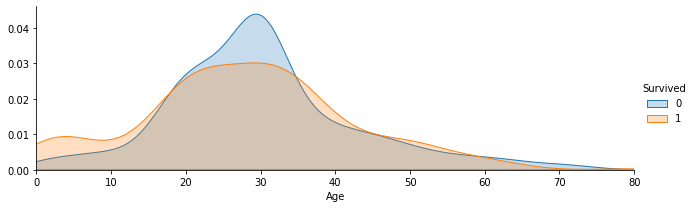

In [ ]:
# 그래프 그려본 후 binning 구간 정하기
# "Age" 구간화 (binning) (1)
fg = sns.FacetGrid(train, hue="Survived",aspect=3)
fg.map(sns.kdeplot,'Age',shade= True)
fg.set(xlim=(0, train['Age'].max()))
fg.add_legend()
plt.show()

# "Age" 구간화 (binning) (2)

#청소년: 0
#청년  : 1
#장년  : 2
#중년  : 3
#노년  : 4

train_test_data= [train, test]
for i in train_test_data:
    i.loc[ i['Age'] <= 16, 'Age'] = 0
    i.loc[(i['Age'] > 16) & (i['Age'] <= 26), 'Age'] = 1
    i.loc[(i['Age'] > 26) & (i['Age'] <= 36), 'Age'] = 2
    i.loc[(i['Age'] > 36) & (i['Age'] <= 62), 'Age'] = 3
    i.loc[ i['Age'] > 62, 'Age'] = 4

In [ ]:
train["Fare_cat"] = np.where((train.Fare < 15), "Low", np.nan)
train["Fare_cat"] = np.where((train.Fare >= 15) & (train.Fare < 35), "Medium", train.Fare_cat)
train["Fare_cat"] = np.where((train.Fare >= 35), "High", train.Fare_cat)

## apply lambda

In [ ]:
df["year"] = df["주민등록번호"].apply(lambda x: str(x)[0:2]).astype('int')

df["month"] = df["주민등록번호"].apply(lambda x: str(x)[2:4])
df['month'] = df['month'].apply(lambda x: x[3] if x[2] == "0" else x[2:4]).astype('int')

In [ ]:
X["gap"] = X["gap"].apply(lambda x: x.days)

## 맵핑 : 인코딩 등

In [ ]:
y_train = np.array([1 if i=="<50" else 0 for i in y_train])

In [ ]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "etc": 3}
for i in [df]:
    i['Title'] = i['Title'].map(title_mapping)

In [ ]:
# 레이블 Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["new"])
# le.classes_
df["new_label"] = le.transform(df["new"])
df.drop('new', axis=1, inplace=True)
df.head()


from kaggler.preprocessing import LabelEncoder
num_cols = [x for x in df.columns if df[x].dtype in [np.int64, np.float64] and x != "box_off_num"]
cat_cols = ['distributor', 'genre', 'screening_rat', 'director']
df2 = df.copy()
le = LabelEncoder(min_obs=2) # 2번 미만 출현한 범주를 묶어서 기타로 라벨링
df2[cat_cols] = le.fit_transform(df[cat_cols])
df2[cat_cols].head()

In [ ]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=["new2", "color"], drop_first=True)


from sklearn.preprocessing import OneHotEncoder
num_cols = [x for x in df.columns if df[x].dtype in [np.int64, np.float64] and x != "box_off_num"]
cat_cols = ['distributor', 'genre', 'screening_rat', 'director']
ohe = OneHotEncoder()
X = hstack((df[num_cols], ohe.fit_transform(df[cat_cols]))) # concat과 비슷한 것


from kaggler.preprocessing import OneHotEncoder
ohe = OneHotEncoder(min_obs=2) # 그룹핑
ohe.fit(df[cat_cols])
X = hstack((df[num_cols], ohe.transform(df[cat_cols])))

In [ ]:
# Target Encoding
# 각각의 범주를 해당 범주에서 종속변수의 평균값 등으로 변환, 과적합에 취약
df[["director", "box_off_num"]].groupby("director").transform("mean")

# without Cross-Validation
from kaggler.preprocessing import TargetEncoder
trn, tst = train_test_split(df, test_size=.2, random_state=seed)
te = TargetEncoder(cv=None)
trn[cat_cols] = te.fit_transform(trn[cat_cols], trn[target_col])
tst[cat_cols] = te.transform(tst[cat_cols])
trn[cat_cols].head()

# with Cross-Validation : 더 좋음
from kaggler.preprocessing import TargetEncoder
trn, tst = train_test_split(df, test_size=.2, random_state=seed)
te = TargetEncoder()
trn[cat_cols] = te.fit_transform(trn[cat_cols], trn[target_col])
tst[cat_cols] = te.transform(tst[cat_cols])
trn[cat_cols].head()

In [ ]:
# Frequency Encoding
# 각각의 범주를 해당 범주의 빈도로 변환
# 실전에서 꽤 좋은 성능을 보여줌
df["director"].value_counts()
df.groupby("director")[["box_off_num"]].transform("count")

from kaggler.preprocessing import FrequencyEncoder
df_cat = df.copy()
fe = FrequencyEncoder()
df_cat[cat_cols] = fe.fit_transform(df[cat_cols])
df_cat[cat_cols].head()

In [ ]:
# Hashing Trick
# 각각의 범주를 Hash함수에 적용한 값으로 변환
# 범주의 갯수가 아무리 많아도 Fast&Low memory
from sklearn.feature_extraction import FeatureHasher
fh = FeatureHasher(n_features=1024, input_type='string') # 1024이상
X = hstack([df[num_cols]] + [fh.fit_transform(df[col]) for col in cat_cols])
df2 = pd.DataFrame(X.toarray(), columns=[i for i in num_cols]+[i for i in range(512)], index=df.index) # 512 변경필요 # Hash함수 적용한 컬럼갯수
df2.head()

## Tip
- 인코딩 시 그룹핑 꼭 고려하기
- 그룹핑(출현빈도가 낮은 데이터는 기타로 묶음)해서 라벨인코딩을 한 후 value_counts를 확인해서 빈도인코딩을 사용하면 좋음
- 타겟을 정하고 각 범주별 그 타겟의 평균값 등으로 변환

## drop


In [ ]:
train.drop('SibSp', axis=1, inplace=True)

## loc

In [ ]:
dead = train.loc[train['Survived']==0, 'Pclass'].value_counts()
dead

## fillna

In [ ]:
train['Embarked'] = train['Embarked'].fillna('S')

In [ ]:
train["Age"].fillna( train.groupby("Title")["Age"].transform("median"), inplace=True )

In [ ]:
df.fillna(-1, inplace=True)

## ndarray -> df

In [ ]:
df = pd.read_csv(feature_dir / 'feature.csv', index_col=0)
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
df_tst = pd.DataFrame(data=tst, columns=feature_name, index=df.iloc[320000:].index)
df_tst.head()

In [ ]:
feature_names = poly.get_feature_names(df.columns)
df_poly = pd.DataFrame(data=X, columns=feature_names, index=df.index)
df_poly[target_col] = df[target_col]
df_poly.head()

df_poly.to_csv(feature_file)
del df_poly, df
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

## log1p, expm1

In [ ]:
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

## to_datetime
- https://docs.python.org/3.2/library/time.html

In [ ]:
pd.to_datetime(df["date"], format="%y-%m-%d")

In [ ]:
# Unix Timestamp = UTC = Universal Time Coordinated
pd.set_option("display.float_format", lambda x: "%.0f" % x)
pd.to_numeric(data["Order Date"]) / 10**9

## 기타

In [ ]:
# 1,2번째 컬럼에 추가하기
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(x=df.index, y=df["sales"])

# 또는

df.plot(figsize=(20,10))

In [ ]:
df.resample("MS").mean() # 월단위 Start

In [ ]:
df[:"2016"] # 2016년도 까지의 데이터

In [ ]:
ax = df.plot()
pred.plot(ax=ax, figsize=(20,10))
plt.show() # 그래프 2개 나올 경우 사용~

In [ ]:
df[["age", "color", "carrier"]].nunique()

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(x=range(1,101), y=error_list, marker="o", markersize=10, markerfacecolor="red")

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [ ]:
import joblib
 
joblib.dump(clf, './lgb.pkl')
clf2 = joblib.load('./lgb.pkl')

## submission

In [ ]:
clf = svm.SVC(gamma='auto')
clf.fit(train_x, train_y)
prediction = clf.predict(test)

test_PassengerId = test["PassengerId"]

submission = pd.DataFrame({
        "PassengerId": test_PassengerId,
        "Survived": prediction
    })
submission.to_csv('submission.csv', index=False)

submission = pd.read_csv('submission.csv')
submission.head()

## 최적 threshold 찾기 & 성능평가
- https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/


In [ ]:
# 2진분류 threshold
threshold = 0.4
p_val = clf.predict_proba(X_val) 
predicted = (p_val[:, 1] >= threshold).astype('int')
accuracy_score(y_val, predicted)

In [ ]:
# 3진분류 threshold
threshold = 0.4
threshold2 = 0.6
p_val = clf.predict_proba(X_val) 
predicted = np.where((p_val[:, 1] < threshold), 0, np.nan)
predicted = np.where((p_val[:, 1] >= threshold) & (p_val[:, 1] < threshold2), 1, a)
predicted = np.where((p_val[:, 1] >= threshold2), 2, a)
accuracy_score(y_val, predicted)


# 3등급으로 예측했는데 실제값이 2등급 또는 4등급이라면 인접 정확도가 높은 것
# 다중분류에서는 예측값이 정확하게 실제값을 맞췄는지를 보는 것보다 인접 정확도도 같이 보는 것이 중요함
precise_accuracy =  np.sum(p_val==y_val) / len(p_val)
adjacent_accuracy =  np.sum(np.abs(p_val - y_val) <= 1) / len(p_val) # 인접 정확도의 계산
print('precise accuracy: {0:0.4f}'. format(precise_accuracy))
print('adjacent accuracy: {0:0.4f}'. format(adjacent_accuracy))

In [ ]:
from sklearn.metrics import classification_report

result =  classification_report(y_val, p_val) 
print(result)

In [ ]:
# False Positive : 1형 오류
# False Negative : 2형 오류
# Accuracy는 클래스 비율이 불균형할 경우 평가지표로서의 신뢰성을 잃을 가능성이 있음
# Precision(정밀도) : 실제로 Negative인 데이터를 Positive라고 판단하면 안되는 경우 사용되는 지표, 즉 FP가 중요할 때!
# Recall(재현율, 민감도, TPR, sensitivity) : 실제로 Positive인 데이터를 Negative라고 판단하면 안되는 경우 사용되는 지표, 즉 FN이 중요할 때!
# Specificity(특이도) : 실제 Negative를 얼마나 잘 예측했는지, TN/(FP+TN)
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_val, p_val)
print('Confusion Matrix for Binary Labels \n')
print('Confusion Matrix for Binary Labels\n')
print('Actual class')
print('Predicted', '[[True Positive', 'False Positive]')
print('         ', '[False Negative', 'True Negative]]')
print(cm)


print('\nRecall for Class [0] = ', cm[0,0], '/' , cm[0,0] + cm[0,1])
print('\nPrecision for Class [0] = ', cm[0,0], '/' , cm[0,0] + cm[1,0])
print('\nRecall for Class [1] = ', cm[1,1], '/' , cm[1,0] + cm[1,1])
print('\nPrecision for Class [1] = ', cm[1,1], '/' , cm[0,1] + cm[1,1])


## 히트맵으로 시각화하기
plt.figure(figsize=[8,7])
sns.heatmap(cm, cmap='Reds', annot=True, fmt='.0f')
plt.title('Heatmap for 3-class Labels\n')
plt.show()

In [ ]:
p_val2 = logreg.predict_proba(X_test)
p_val2 = p_val2[:, 1]

In [ ]:
from numpy import argmax, sqrt
from sklearn.metrics import classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, p_val2)
gmean = sqrt(tpr * (1-fpr)) # 기하평균
ix = argmax(gmean) # locate the index of the largest G-Mean
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmean[ix]))

Best Threshold=0.771365, G-Mean=0.742


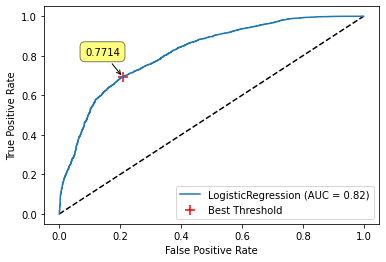

In [ ]:
ax = plt.figure().gca()
plt.plot([0,1], [0,1], linestyle='--', color='black')
plot_roc_curve(logreg, X_test, y_test, ax=ax)
# plt.plot(fpr, tpr, label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', label='Best Threshold')
label = str(round(thresholds[ix], 4))
plt.annotate(
    label,
    xy=(fpr[ix], tpr[ix]), xytext=(-20, 20),
    textcoords='offset points', ha='center', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
    arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() # 범례
plt.show()

### F1 Score
- Precision과 Recall의 조화평균 함으로써 큰 값의 크기에 대한 가중치를 낮추고 작은 값에 더 맞춰주는 과정을 거쳐서 불균형 데이터일지라도 값의 크기 차이가 어느정도 상쇄되기 때문에 F1 Score는 불균형 데이터에서의 주요 척도
- 불균형 분류문제에서 평가척도로 주로 사용됨
- 데이터가 불균형한 상태에서 Accuracy로 성능을 평가하기엔 데이터 편향성이 너무 크게 나타나 올바르게 성능을 측정하기 힘듦
- precision 또는 recall이 0에 가까울수록 F1-Score도 동일하게 낮은 값을 갖도록 하기위함 
- 일반적인 산술평균 사용 시에는 실제보다 성능이 좋아보이는 착시를 줌

In [ ]:
from numpy import argmax, sqrt
from sklearn.metrics import classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, p_val2)
f1score = (2 * precision * recall) / (precision + recall) # 조화평균 
ix = argmax(f1score) # locate the index of the largest F1-Score
print('Best Threshold=%f, F1-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.314758, F1-Score=0.886


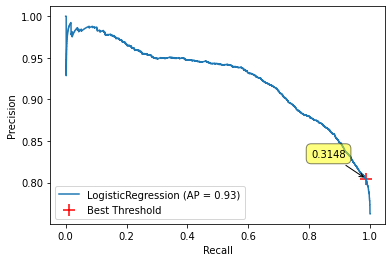

In [ ]:
ax = plt.figure().gca()
plot_precision_recall_curve(logreg, X_test, y_test, ax=ax)
# plt.plot(recall, precision, label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='+', s=150, color='r', label='Best Threshold')
label = str(round(thresholds[ix], 4))
plt.annotate(
    label,
    xy=(recall[ix], precision[ix]), xytext=(-20, 20),
    textcoords='offset points', ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
    arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

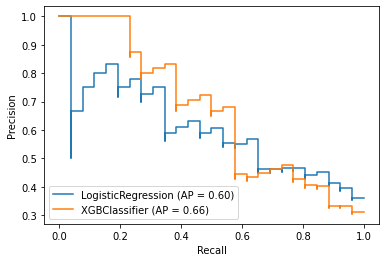

In [ ]:
# Precision-Recall 커브
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca()
plot_precision_recall_curve(model_lr, X_val, y_val, ax=ax)
plot_precision_recall_curve(model_xgb, X_val, y_val, ax=ax)
# AP가 1에 가까울수록 Recall을 증가시키면서 Precision을 잘 유지했다는 좋은 의미

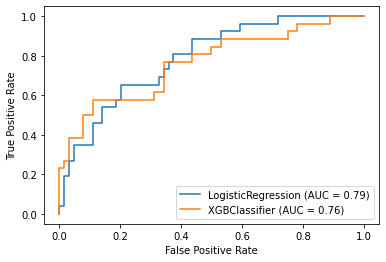

In [ ]:
# ROC 커브
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca()
plot_roc_curve(model_lr, X_val, y_val, ax=ax)
plot_roc_curve(model_xgb, X_val, y_val, ax=ax)
# AUC(Area Under Curve)가 높을수록 좋음

In [ ]:
from kaggler.metrics import plot_roc_curve, plot_pr_curve

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plot_roc_curve(y_val, predicted);
plt.title('AUC Curve')
plt.subplot(1, 2, 2)
plot_pr_curve(y_val, predicted);
plt.title('Precision-Recall Curve')

In [ ]:
# 불균형 데이터에서 샘플갯수가 현저히 낮은 클래스의 precision은 당연히 낮을수밖에 없음
# 이런 상황에서 precision이 0.46이면 꽤 높은 것
# recall을 더 유의하게 봐야 함
from imblearn.metrics import classification_report_imbalanced

label = ['non-fraud', 'fraud'] 
print(classification_report_imbalanced(y_val, p_val, target_names=label))

## ODDS 분석

- ODDS는  항목의 우불량 변별력을 나타내는 통계적 지표임
- ODDS = 우량구성비/불량구성비
- ODDS가 1보다 크면 클수록 우량으로의 경향이, 1보다 작으면 작을수록 불량으로의 경향이, ODDS=1이면 불량과 우량의 경향이 같다고 봄
- 1을 기준으로 하여 상하로 벌어진 정도로서 변별력을 측정하며 벌어진 정도가 클수록 우불량에의 영향력이 크다고 판단함 
- 1로부터의 좌우대칭성을 갖기 위해 ODDS가 1보다 작은 경우 2-1/ODDS로 변환하여 분석함
- 예시 : 항목2의 구간값별 우불량 변별력이 상대적으로 매우 높음



In [ ]:
df.groupby("sex")["income"].value_counts()

sex     income
Female  1          9592
        0          1179
Male    1         15128
        0          6662
Name: income, dtype: int64

In [ ]:
x_plot = ["Y", "N"]

odds = []
# x_plot = []
origin = df.groupby("sex")["income"].value_counts()
for i in range(0, len(origin), 2):
  b = origin[i]/origin[i+1]
  if b < 1:
    b = 2-1/b
  odds.append(b)

  # c = origin.index[i][0]
  # x_plot.append(c)
odds

[8.13570822731128, 2.270789552686881]

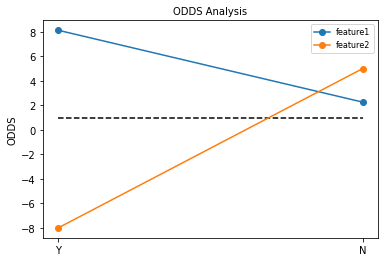

In [ ]:
plt.plot([0,1], [1,1], linestyle='--', color='black')
plt.plot(x_plot, odds, marker='o', label="feature1")
plt.plot(x_plot, odds2, marker='o', label="feature2")
plt.title('ODDS Analysis', fontsize=10) 
# plt.xlabel('bin')
plt.ylabel('ODDS')
plt.legend(fontsize=8, loc='best')
plt.show()

## KS 통계량

- Kolmogorov-Smirnov Statistics
- K-S통계량은 우량집단과 불량집단의 누적분포의 차이를 나타내는 지표
- 우불량 집단의 분포차이로 누적 우량비율과 누적 불량비율 차이의 최대 값을 K-S 통계량으로 정의
- KS = Max|누적우량구성비-누적불량구성비|
- K-S 통계량이 20 이상인 경우 신용평가모형의 변별력이 확보되는 것으로 판단
- K-S 통계량이 50이상이면 우수한 모형으로 판단

In [ ]:
temp = df[df["income"]==1][["age","income"]].sort_values(by="age")
temp = temp.groupby("age").count()
temp["cum"] = temp.cumsum()
temp["cum_%"] = temp["cum"]/temp["cum"].tail(1).values[0]
temp = temp.reset_index()
temp

,age,income,cum,cum_%
0,17,395,395,0.015979
1,18,550,945,0.038228
2,19,710,1655,0.066950
3,20,753,2408,0.097411
4,21,717,3125,0.126416
...,...,...,...,...
68,85,3,24680,0.998382
69,86,1,24681,0.998422
70,87,1,24682,0.998463
71,88,3,24685,0.998584


In [ ]:
temp2 = df[df["income"]==0][["age","income"]].sort_values(by="age")
temp2 = temp2.groupby("age").count()
temp2["cum"] = temp2.cumsum()
temp2["cum_%"] = temp2["cum"]/temp2["cum"].tail(1).values[0]
temp2 = temp2.reset_index()
temp2

,age,income,cum,cum_%
0,19,2,2,0.000255
1,21,3,5,0.000638
2,22,13,18,0.002296
3,23,12,30,0.003826
4,24,31,61,0.007780
...,...,...,...,...
60,80,2,7827,0.998215
61,81,3,7830,0.998597
62,83,2,7832,0.998852
63,84,1,7833,0.998980


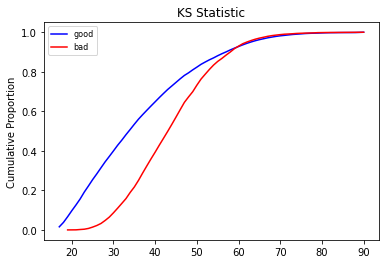

In [ ]:
import matplotlib.pyplot as plt
plt.plot(temp["age"], temp["cum_%"], color="b", label="good") # 우량누적비
plt.plot(temp2["age"], temp2["cum_%"], color="r", label="bad") # 불량누적비
plt.title('KS Statistic', fontsize=12) 
# plt.xlabel('bin')
plt.ylabel('Cumulative Proportion')
plt.legend(fontsize=8, loc='best')
plt.show()

In [ ]:
temp_df = pd.merge(temp, temp2, how="right", on="age") # 또는 temp = temp.merge(temp2)
temp_df["ks"] = temp_df["cum_%_x"]-temp_df["cum_%_y"]
temp_df

,age,income_x,cum_x,cum_%_x,income_y,cum_y,cum_%_y,ks
0,19,710,1655,0.066950,2,2,0.000255,0.066695
1,21,717,3125,0.126416,3,5,0.000638,0.125778
2,22,752,3877,0.156837,13,18,0.002296,0.154541
3,23,865,4742,0.191828,12,30,0.003826,0.188002
4,24,767,5509,0.222856,31,61,0.007780,0.215076
...,...,...,...,...,...,...,...,...
60,80,20,24635,0.996561,2,7827,0.998215,-0.001653
61,81,17,24652,0.997249,3,7830,0.998597,-0.001348
62,83,4,24668,0.997896,2,7832,0.998852,-0.000956
63,84,9,24677,0.998261,1,7833,0.998980,-0.000719


In [ ]:
max(temp_df["ks"])

0.3233389733411093

In [ ]:
temp_df.loc[temp_df['ks']==0.3233389733411093]

,age,income_x,cum_x,cum_%_x,income_y,cum_y,cum_%_y,ks
13,33,684,11918,0.48212,191,1245,0.158781,0.323339


## H2O

In [ ]:
C:\Users\11lal\Downloads\h2o-3.32.1.5>cd h2o-3.32.1.5
java -jar h2o.jar
http://localhost:54321

# 트리기반 모델
- Decision Trees, Random Forests, XGBoost, Light GBM
- 스케일링 적용 안 해도 됨
- 지니불순도와 엔트로피 : 50%/50%로 구분하는 것은 못하는 것, 이렇게 못할수록 1에 가까움, 잘할수록 값이 낮아짐


## Decision Trees(결정트리) 분류학습
- 범주를 가장 잘 구분할 수 있는 변수와 그 변수의 기준값을 기준으로 자식 노드를 구분
- max_depth=2 이면 층이 3개
- bias(틀릴확률)는 낮지만 variance는 높아서 전체적인 에러가 높음

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X_train.columns, fontsize=15, label="None", max-depth=3) # 3층까지만 보여주고 나머지는 생략

## Random Forest(RF)
- 2010년 초반까지 가장 많이 사용된 결정트리 기반 앙상블(Ensemble) 알고리즘
- variance가 높은 결정트리를 여러 개 조합시켜서 (높은 variance가 효과적으로 감소되어) 성능이 전반적으로 향상됨
- 피쳐와 샘플이 각기 다른 트리가 여러 개
- 확률예측값을 평균내서 최종예측값을 결정함

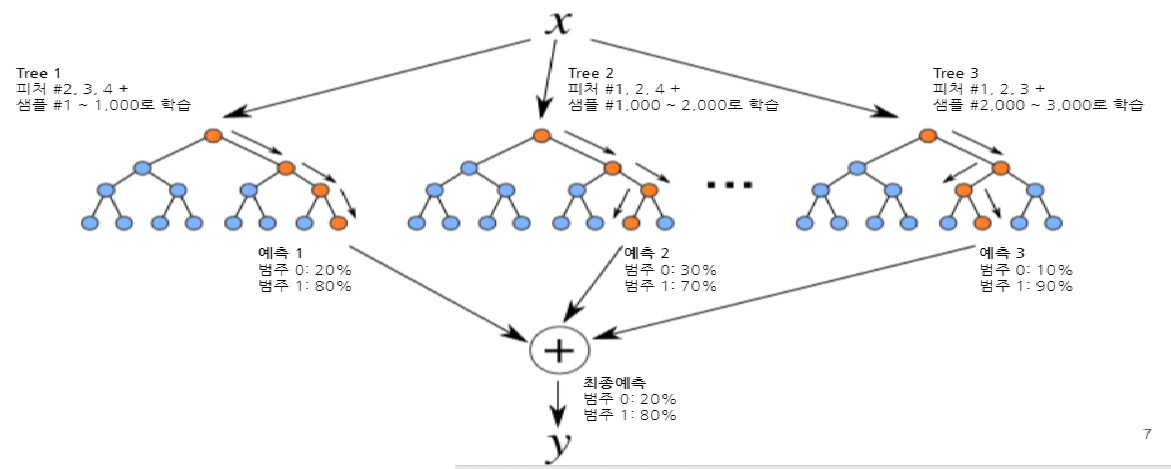

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# max_features=.5 : 개별 결정트리를 만들 때 피쳐의 50%를 샘플링
# max_features=7 : 개별 결정트리를 만들 때 피쳐를 7개 샘플링
# n_jobs=0 : 1개의 thread만 사용해서 학습 
# n_jobs=-1 : 시스템에서 사용가능한 모든 cpu 자원을 활용해서 병렬처리로 학습하여 더 빠름
clf = RandomForestClassifier(n_estimators=100,
                             min_sample_leaf=10,
                             max_features="auto",
                             max_samples=.5,
                             random_state=seed,
                             n_jobs=-1)

clf.fit(X_trn, y_trn)
np.unique(y_trn)

p_val = clf.predict(X_val)
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')
p_tst = clf.predict(tst)

p_val = clf.predict_proba(X_val)
X_val["score"] = p_val[:, 0]

# 번외 : 가장 큰 확률
max_value = []
for i in p_val:
    max_value.append(np.max(i))
X_val["score2"] = max_value
X_val.head()

In [ ]:
imp = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh');

## GBM(Gradient Boosting Machine)
- 여러 결정트리를 이전 트리의 오차를 줄이는 방향으로 순차적 학습
- 개별 결정트리의 bias를 효과적으로 감소시켜 성능향상
- XGBoost
- LightGBM : 상대적으로 빠르고 성능도 비슷하거나 약간 더 좋음

In [ ]:
import lightgbm as lgb

# learning_rate 이 1/10 줄어들면 n_estimators는 10배 늘어남
# min_child_samples = min_sample_leaf = 마지막 노드에 최소 몇 개 이상의 샘플이 있어야하는지
# subsample=.5 : 개별 결정트리에서 전체의 50% 데이터로만 학습
# colsample_bytree = max_features =.8 = 개별 결정트리를 만들 때 피쳐의 80%를 샘플링
# n_estimators가 아무리 크더라도 early_stopping_rounds로 인해서 모델이 알아서 적절한 시점에서 중단함
# learning_rate이 높아서 발산할 확률이 높을 때에는 early_stopping_rounds를 늘려줌
clf = lgb.LGBMClassifier(objective='binary',
                         n_estimators=1000,
                         num_leaves=64,
                         learning_rate=0.1,
                         min_child_samples=10,
                         subsample=.5,
                         subsample_freq=1,
                         colsample_bytree=.8,
                         random_state=seed,
                         n_jobs=-1)

clf.fit(X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='binary',
        early_stopping_rounds=10)

p_val = clf.predict(X_val)
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%')
p_tst = clf.predict(tst)

## SMOTE
- Syntehtic Minority Oversampling Technique
- 소수 클래스를 오버샘플링해서 합성

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_resampled, y_resampled = sm.fit_sample(X_train, list(y_train))


print('Before SMOTE, original X_train: {}'.format(X_train.shape)) 
print('Before SMOTE, original y_train: {}'.format(np.array(y_train).shape))
print('After  SMOTE, resampled original X_train: {}'.format(X_resampled.shape)) 
print('After  SMOTE, resampled original y_train: {} \n'.format(np.array(y_resampled).shape))

print("Before SMOTE,     fraud counts: {}".format(sum(np.array(y_train)==1)))
print("Before SMOTE, non-fraud counts: {}".format(sum(np.array(y_train)==0)))
print("After  SMOTE,     fraud counts: {}".format(sum(np.array(y_resampled)==1)))
print("After  SMOTE, non-fraud counts: {}".format(sum(np.array(y_resampled)==0)))

## 딥러닝
- 딥러닝 모델이 학습을 잘하기 위해서는 정규화(MinMaxScaler 등) 작업이 필요

### Semi Supervised Classification using AutoEncoders
- Semi-Supervised Learning
- combination of supervised and unsupervised learning processes in which the unlabelled data is used for training a model as well
- 오토인코더는 bad그룹의 독립변수들만 사용하여 학습함
- 인코더를 통해 얻은 밀집된 벡터값(Latent Representations)을 LR의 X_학습데이터로 사용
- 여기서 LR은 라벨이 있는 지도학습
- 아래 예제는 히든레이어가 3개(코딩은 인코더2+디코더2)

In [ ]:
###
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

In [ ]:
df.shape

(32561, 13)

In [ ]:
###
vc = df['income'].value_counts().to_frame().reset_index()
vc['percent'] = vc["income"].apply(lambda x : round(100*float(x) / len(df), 2))
vc = vc.rename(columns = {"index" : "Target", "income" : "Count"})
vc

,Target,Count,percent
0,0,24720,75.92
1,1,7841,24.08


In [ ]:
###
bad = df[df['income'] == 0]
good = df[df['income'] == 1]

df = bad.append(good).sample(frac=1).reset_index(drop=True)
X = df.drop(['income'], axis = 1).values
Y = df["income"].values
X

array([[  47,    3,   13, ..., 2258,   40,   38],
       [  66,    3,    7, ...,    0,   20,   38],
       [  60,    5,    9, ...,    0,   50,   38],
       ...,
       [  36,    0,    9, ...,    0,   36,   38],
       [  36,    6,   14, ...,    0,   40,   38],
       [  43,    6,    9, ...,    0,   40,   38]])

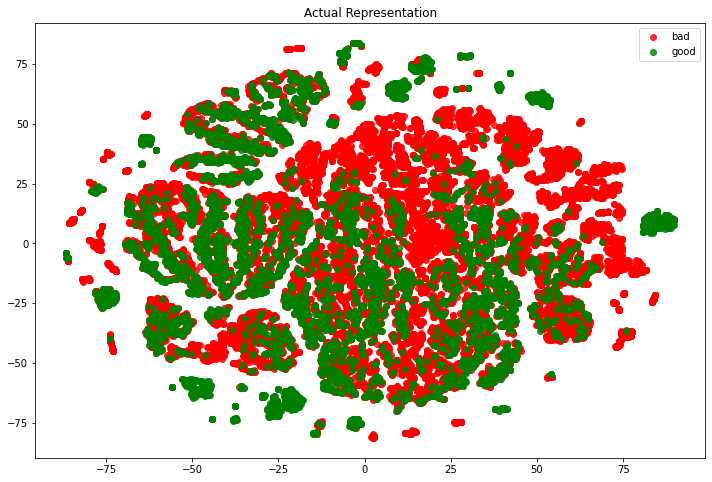

In [ ]:
###
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='bad')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='good')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.title("Actual Representation");
    plt.show();
    
tsne_plot(X, Y, "original.png")

In [ ]:
###
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(encoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [ ]:
###
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [ ]:
###
x = df.drop(["income"], axis=1)
y = df["income"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_bad, x_good = x_scale[y == 0], x_scale[y == 1]

In [ ]:
###
autoencoder.fit(x_bad, x_bad, 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Epoch 1/10
78/78 [==============================] - 1s 5ms/step - loss: 0.2513 - val_loss: 0.2496
Epoch 2/10
78/78 [==============================] - 0s 3ms/step - loss: 0.2474 - val_loss: 0.2448
Epoch 3/10
78/78 [==============================] - 0s 4ms/step - loss: 0.2413 - val_loss: 0.2377
Epoch 4/10
78/78 [==============================] - 0s 4ms/step - loss: 0.2340 - val_loss: 0.2304
Epoch 5/10
78/78 [==============================] - 0s 4ms/step - loss: 0.2267 - val_loss: 0.2233
Epoch 6/10
78/78 [==============================] - 0s 3ms/step - loss: 0.2198 - val_loss: 0.2166
Epoch 7/10
78/78 [==============================] - 0s 4ms/step - loss: 0.2132 - val_loss: 0.2101
Epoch 8/10
78/78 [==============================] - 0s 3ms/step - loss: 0.2069 - val_loss: 0.2040
Epoch 9/10
78/78 [==============================] - 0s 3ms/step - loss: 0.2009 - val_loss: 0.1981
Epoch 10/10
78/78 [==============================] - 0s 3ms/step - loss: 0.1951 - val_loss: 0.1924


In [ ]:
###
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [ ]:
###
bad_hid_rep = hidden_representation.predict(x_bad)
good_hid_rep = hidden_representation.predict(x_good)

In [ ]:
x_bad

array([[0.67123288, 0.42857143, 0.4       , ..., 0.        , 0.19387755,
        0.95      ],
       [0.5890411 , 0.71428571, 0.53333333, ..., 0.        , 0.5       ,
        0.95      ],
       [0.32876712, 0.71428571, 0.53333333, ..., 0.        , 0.39795918,
        0.95      ],
       ...,
       [0.26027397, 0.        , 0.53333333, ..., 0.        , 0.35714286,
        0.95      ],
       [0.26027397, 0.85714286, 0.86666667, ..., 0.        , 0.39795918,
        0.95      ],
       [0.35616438, 0.85714286, 0.53333333, ..., 0.        , 0.39795918,
        0.95      ]])

In [ ]:
bad_hid_rep

array([[0.        , 0.        , 0.        , ..., 0.03671459, 0.10732648,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.04163152, 0.08357203,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.06006759,
        0.        ],
       ...,
       [0.        , 0.03846769, 0.        , ..., 0.        , 0.23480393,
        0.        ],
       [0.        , 0.02725893, 0.        , ..., 0.2120866 , 0.21128273,
        0.        ],
       [0.        , 0.01962187, 0.        , ..., 0.06897608, 0.10304839,
        0.        ]], dtype=float32)

In [ ]:
x_bad.shape

(24720, 12)

In [ ]:
bad_hid_rep.shape

(24720, 50)

In [ ]:
###
def tsne_plot2(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='bad')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='good')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.title("Latent Representation");
    plt.show();

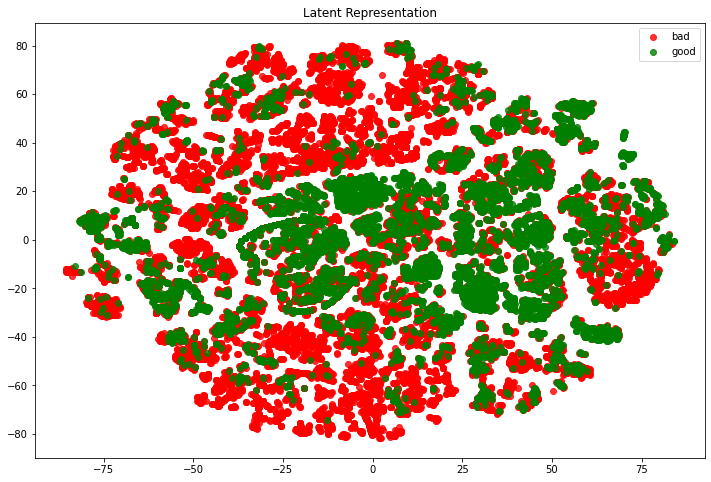

In [ ]:
###
rep_x = np.append(bad_hid_rep, good_hid_rep, axis = 0)
y_b = np.zeros(bad_hid_rep.shape[0]) # 라벨0
y_g = np.ones(good_hid_rep.shape[0]) # 라벨1
rep_y = np.append(y_b, y_g)
tsne_plot2(rep_x, rep_y, "latent_representation.png")

In [ ]:
###
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.84      0.94      0.88      6147
         1.0       0.69      0.44      0.54      1994

    accuracy                           0.81      8141
   macro avg       0.76      0.69      0.71      8141
weighted avg       0.80      0.81      0.80      8141


Accuracy Score:  0.814641935880113


In [ ]:
rep_x.shape

(32561, 50)

### fastai
- https://colab.research.google.com/drive/17lv1_xa8lYCe0Q-qcrfCiJ6nhoTDZxnX?usp=sharing

### TabNet
- Google Cloud AI의 연구팀에서 개발한 신경 아키텍처
- 트리 기반 모델의 변수선택 특징을 네트워크 구조에 반영한 딥러닝 모델
- 설명가능한 모델
- 순차적인 어텐션을 사용하여 각 의사결정 단계에서 추론할 특징을 선택하여 학습능력이 가장 두드러진 특징을 사용

In [ ]:
pip install pytorch_tabnet

In [ ]:
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
seed = 42
target_col = 'income' # y 컬럼명
y_trn1 = df[target_col].values[:26000] # 학습1에서 y값
y_tst = df[target_col].values[26000:] # 학습1에서 y값

df.drop(target_col, axis=1, inplace=True)
X_trn1 = df.iloc[:26000].values # 학습1에서 X값
X_tst = df.iloc[26000:].values # 테스트에서 X값

feature_name = df.columns.tolist()

In [ ]:
X_trn, X_val, y_trn, y_val = train_test_split(X_trn1, y_trn1, test_size=.2, random_state=seed)

- 간단한 방법

In [ ]:
classifier = TabNetClassifier(verbose=0,seed=42)
classifier.fit(X_train=X_trn, y_train=y_trn,
               patience=5,max_epochs=100,
               eval_metric=['auc'])

p_tst = classifier.predict_proba(X_tst)[:,1]
p_tst

No early stopping will be performed, last training weights will be used.


array([0.00967545, 0.41828078, 0.9159401 , ..., 0.00511166, 0.00117833,
       0.5463272 ], dtype=float32)

In [ ]:
p_tst = (p_tst >= 0.5).astype('int')
p_tst

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
accuracy_score(p_tst, y_tst)

0.8431641518061271

- 더 정교한 방법

In [ ]:
# define the model
classifier = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

# fit the model 
classifier.fit(
    X_trn, y_trn,
    eval_set=[(X_trn, y_trn), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['auc','accuracy'],
    max_epochs=1000 , patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)    

Device used : cpu
epoch 0  | loss: 0.47056 | train_auc: 0.76329 | train_accuracy: 0.34639 | valid_auc: 0.75445 | valid_accuracy: 0.33558 |  0:00:03s
epoch 1  | loss: 0.40887 | train_auc: 0.88882 | train_accuracy: 0.62678 | valid_auc: 0.88936 | valid_accuracy: 0.62212 |  0:00:06s
epoch 2  | loss: 0.39657 | train_auc: 0.89904 | train_accuracy: 0.73365 | valid_auc: 0.90147 | valid_accuracy: 0.74423 |  0:00:09s
epoch 3  | loss: 0.3997  | train_auc: 0.90449 | train_accuracy: 0.77784 | valid_auc: 0.9078  | valid_accuracy: 0.7875  |  0:00:13s
epoch 4  | loss: 0.39565 | train_auc: 0.90331 | train_accuracy: 0.80971 | valid_auc: 0.90529 | valid_accuracy: 0.815   |  0:00:16s
epoch 5  | loss: 0.38455 | train_auc: 0.90563 | train_accuracy: 0.80188 | valid_auc: 0.90706 | valid_accuracy: 0.80923 |  0:00:19s
epoch 6  | loss: 0.39462 | train_auc: 0.9079  | train_accuracy: 0.80918 | valid_auc: 0.90961 | valid_accuracy: 0.81231 |  0:00:22s
epoch 7  | loss: 0.39036 | train_auc: 0.90661 | train_accuracy: 0

In [ ]:
# determine best accuracy for test set
test_acc = accuracy_score(p_tst, y_tst)

# determine best accuracy for validation set
p_val = classifier.predict(X_val)
valid_acc = accuracy_score(p_val, y_val)

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")

BEST ACCURACY SCORE ON VALIDATION SET : 0.8198076923076923
BEST ACCURACY SCORE ON TEST SET : 0.8180155464106081


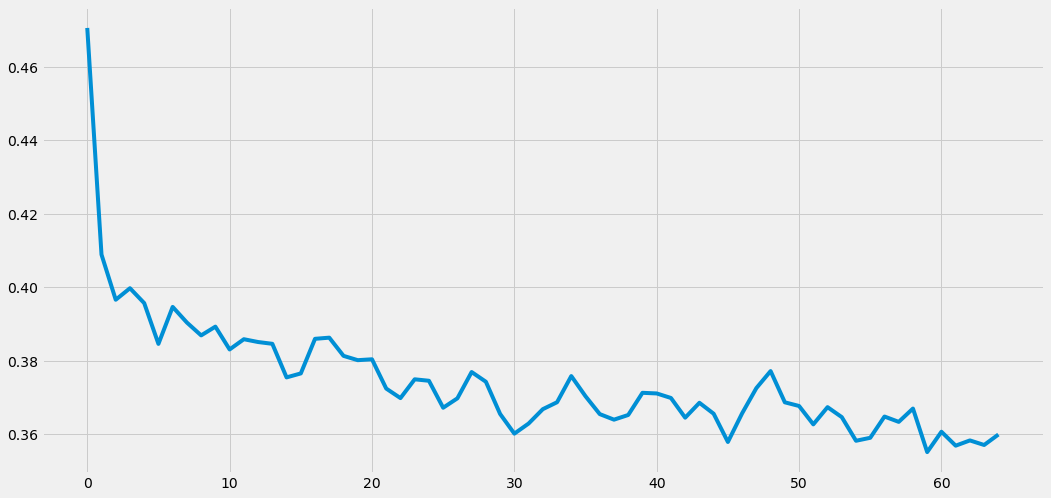

In [ ]:
# plot losses
plt.plot(classifier.history['loss']);

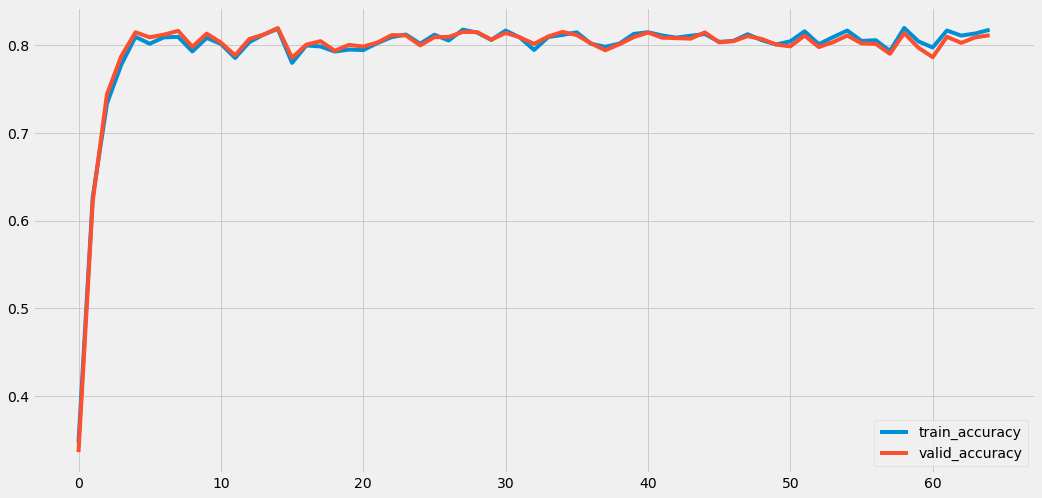

In [ ]:
# plot accuracy
plt.plot(classifier.history['train_accuracy'], label="train_accuracy")
plt.plot(classifier.history['valid_accuracy'], label="valid_accuracy")
plt.legend();

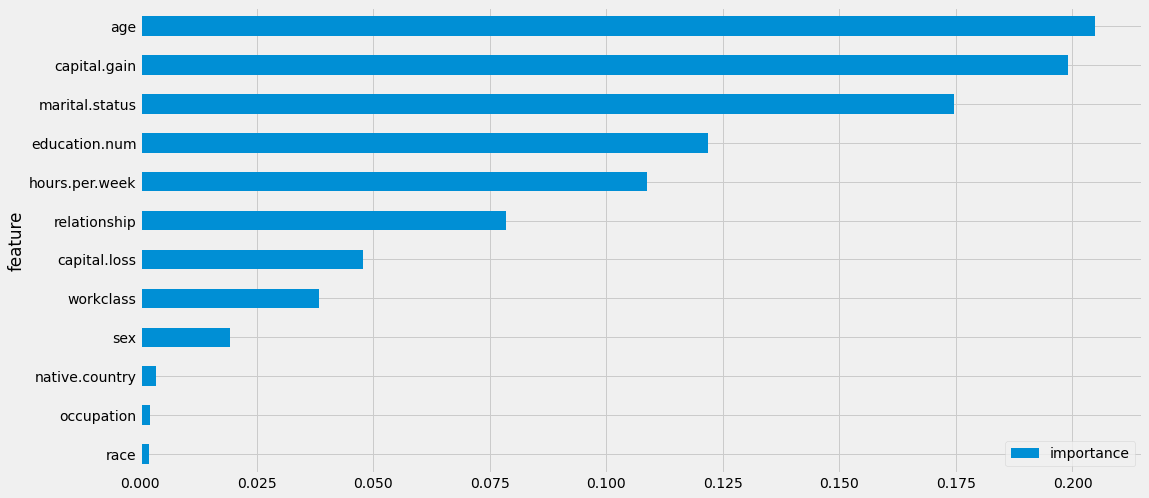

In [ ]:
imp = pd.DataFrame({'feature': feature_name, 'importance': classifier.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh');